In [1]:
# We import the neccessary packages in the beginning
import os
import math
from statistics import mean,stdev
import pm4py
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.conversion.bpmn import converter as bpmn_converter
from sklearn.impute import SimpleImputer
import copy
import numpy as np
import pandas as pd
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from imblearn.under_sampling import OneSidedSelection
from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import sklearn
import tqdm
import time
import xgboost as xgb

In [2]:
# Returns a path to the file selected by the user
# Input: The folder in which to look for the files - the default is the current folder
def ask_for_path(rel_path='', index = -1):
    #Crawl all files in the input folder
    print("The following files are available in the input folder:\n")

    count = 0
    file_list = os.listdir(os.getcwd() + rel_path)
    for file in file_list:
        print(str(count) + " - " + file)
        count+=1

    if(index == -1):
        #Ask for which of the files shall be transformed and select it.
        inp = input("Please choose from the list above which of the files shall be transformed by typing the corresponding number.")
    else:
        #Automatic iteration
        print('Automatic Iteration.')
        inp = index

    input_file = file_list[int(inp)]

    return (os.getcwd() + rel_path + input_file)

In [3]:
# this is a help function to print petri nets
def output_petri_net(net, initial_marking, final_marking, file_name, label):

    #init visualizer
    parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: OUTPUT_FORMAT, 'label':'The Round Table'}   #Add frequency to graph
    gviz = pn_visualizer.apply(net, initial_marking, final_marking, parameters=parameters,
                               variant=pn_visualizer.Variants.FREQUENCY, log=log)

    gviz.attr(label=label)
    pn_visualizer.save(gviz, os.getcwd() + REL_OUTPUT_PATH + file_name + "." + OUTPUT_FORMAT)

In [5]:
# this function converts a selected file in the path that is the input into a log
def transform_to_log(file_path):
    filename, file_extension = os.path.splitext(file_path)
    x,z =os.path.split(file_path)
    
    if file_extension == '.csv':
        log_csv = pd.read_csv(file,sep=None,encoding='utf-8-sig')
        if z =='mobis_challenge_log_2019.csv' or z =='mobis_challenge_log_2019_only_complete_cases.csv':
            log_csv['end'] = pd.to_datetime(log_csv['end'])
            log_csv['start'] = pd.to_datetime(log_csv['start'])
            log_csv['cost'] = log_csv['cost'].apply(pd.to_numeric, errors='coerce')
            log_csv.rename(columns={'cost': 'case:cost','case':'case:concept:name','activity':'concept:name','end':'time:timestamp', 'user':'org:resource'}, inplace=True)
        elif z =='mobis_challenge_log_2019_original.csv':
            log_csv['end'] = pd.to_datetime(log_csv['end'])
            log_csv['start'] = pd.to_datetime(log_csv['start'])
            log_csv['cost'] = log_csv['cost'].apply(pd.to_numeric, errors='coerce')
            log_csv.rename(columns={'case':'case:concept:name','activity':'concept:name','start':'time:timestamp', 'user':'org:resource'}, inplace=True)
        log_csv['time:timestamp'] = pd.to_datetime(log_csv['time:timestamp'], format='mixed')
        log = log_converter.apply(log_csv)

    elif file_extension == '.xes':
        log = pm4py.read_xes(file_path)
        log = pm4py.convert_to_event_log(log)
    elif file_extension == '.dfg':
        log = pm4py.read_dfg(file_path)
    else:
        print("Current filetype is equal to {}. \nPlease input a file with any of the following extensions: - csv; - xes; - dfg".format(str(file_extension)))
        return -1

    return log

In [6]:
def get_all_activities_from_log(log):
    activities=[]
    for trace in log:
        for event in trace:
            if activities.count(event['concept:name'])==0:
                activities.append(event['concept:name'])
    return activities

In [94]:
##########
"""Settings"""
##########
# set the input and output path according to the files you want to select
REL_INPUT_PATH = "/uploads/" # here lie the event logs (.csv), the to-be model (.bpmn) and the already aligned traces (.pkl)

In [129]:
# generate the log from the input path
file= ask_for_path(REL_INPUT_PATH,14) # adjust to your path
log=transform_to_log(file)
file= ask_for_path(REL_INPUT_PATH,5) # adjust to your path
bpmn=pm4py.read_bpmn(file)


The following files are available in the input folder:

0 - sepsis.xes
1 - Road_Traffic_Fine_Management_Process.xes
2 - .DS_Store
3 - road_traffic.bpmn
4 - Model_DomesticDeclarations.bpmn
5 - Model_RequestForPayment.bpmn
6 - InternationalDeclarations.xes
7 - loan_application.xes
8 - Model_PrepaidTravelCost.bpmn
9 - sepsis.bpmn
10 - BPIC12_Log_onlyA.csv
11 - default.xes
12 - BPIC12_Log_onlyO.csv
13 - Model_A_corrected.bpmn
14 - RequestForPayment.xes
15 - PrepaidTravelCost.xes
16 - DomesticDeclarations.xes
17 - default.bpmn
18 - Model_InternationalDeclarations.bpmn
19 - loan_application_simple.bpmn
20 - Model_O.bpmn
Automatic Iteration.


parsing log, completed traces ::   0%|          | 0/6886 [00:00<?, ?it/s]

The following files are available in the input folder:

0 - sepsis.xes
1 - Road_Traffic_Fine_Management_Process.xes
2 - .DS_Store
3 - road_traffic.bpmn
4 - Model_DomesticDeclarations.bpmn
5 - Model_RequestForPayment.bpmn
6 - InternationalDeclarations.xes
7 - loan_application.xes
8 - Model_PrepaidTravelCost.bpmn
9 - sepsis.bpmn
10 - BPIC12_Log_onlyA.csv
11 - default.xes
12 - BPIC12_Log_onlyO.csv
13 - Model_A_corrected.bpmn
14 - RequestForPayment.xes
15 - PrepaidTravelCost.xes
16 - DomesticDeclarations.xes
17 - default.bpmn
18 - Model_InternationalDeclarations.bpmn
19 - loan_application_simple.bpmn
20 - Model_O.bpmn
Automatic Iteration.


In [130]:
from pm4py.statistics.traces.generic.log import case_statistics
from pm4py.objects.petri_net.utils import petri_utils

def print_log_petri_stats(event_log, petri_net, initial_marking, final_marking):
    """
    Prints statistics for a given event log and Petri net process model.

    Parameters:
    - event_log: pm4py EventLog object
    - petri_net: pm4py PetriNet object
    - initial_marking: pm4py Marking object (initial marking of the Petri net)
    - final_marking: pm4py Marking object (final marking of the Petri net)
    """

    # Number of traces
    num_traces = len(event_log)

    # Number of variants
    variants_count = len(case_statistics.get_variant_statistics(event_log))

    # Number of activities in Petri net (transitions with a label)
    activities_in_model = len([t.label for t in petri_net.transitions if t.label is not None])

    # Average number of activities per trace
    avg_activities_per_trace = sum(len(trace) for trace in event_log) / num_traces if num_traces > 0 else 0

    # Number of event attributes
    event_attrs = set()
    for trace in event_log:
        for event in trace:
            event_attrs.update(event.keys())
    num_event_attrs = len(event_attrs)

    # Number of trace attributes
    trace_attrs = set()
    for trace in event_log:
        trace_attrs.update(trace.attributes.keys())
    num_trace_attrs = len(trace_attrs)

    # Print results
    print("📊 Event Log + Petri Net Statistics:")
    print(f"- Number of traces: {num_traces}")
    print(f"- Number of variants: {variants_count}")
    print(f"- Number of activities in process model: {activities_in_model}")
    print(f"- Average number of activities per trace: {avg_activities_per_trace:.2f}")
    print(f"- Number of event attributes: {num_event_attrs}")
    print(f"- Number of trace attributes: {num_trace_attrs}")


In [131]:
net, initial_marking, final_marking = pm4py.convert.convert_to_petri_net(bpmn)
print_log_petri_stats(log, net, initial_marking, final_marking)

📊 Event Log + Petri Net Statistics:
- Number of traces: 6886
- Number of variants: 89
- Number of activities in process model: 13
- Average number of activities per trace: 5.34
- Number of event attributes: 5
- Number of trace attributes: 9


In [113]:
len(pm4py.statistics.traces.generic.log.case_statistics.get_variant_statistics(log))

17

In [72]:
event_attribtues=pm4py.get_event_attributes(log)
event_attribtues.remove('time:timestamp')
event_attribtues

['concept:name', 'Unnamed: 0', 'org:resource']

In [73]:
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.algo.conformance.alignments.petri_net import algorithm as alignments
def calculate_alignments(log,bpmn):

    net, initial_marking, final_marking = pm4py.convert.convert_to_petri_net(bpmn)
    aligned_traces = alignments.apply_log(log, net, initial_marking, final_marking)

    return aligned_traces
aligned_traces=calculate_alignments(log,bpmn)

aligning log, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

In [74]:
from collections import defaultdict
def get_conformance_by_event_attribute(log, aligned_traces):

    # Get all attributes from events
    event_attributes = pm4py.get_event_attributes(log)
    trace_attributes = pm4py.get_trace_attributes(log)
    event_attributes.remove('time:timestamp')
    event_attributes.remove('concept:name')

    print(event_attributes)
    # Dictionary to hold: {attribute: {value: [fitness_scores]}}
    attribute_conformance = defaultdict(lambda: defaultdict(list))

    for i, trace in enumerate(log):
        fitness = aligned_traces[i].get("fitness", 0)

        # ----- EVENT ATTRIBUTE PROCESSING -----
        seen_event_values = defaultdict(set)
        for event in trace:
            for attr in event_attributes:
                if attr in event:
                    seen_event_values[attr].add(event[attr])

        for attr, values in seen_event_values.items():
            for value in values:
                if value is not None:
                    attribute_conformance[f"event:{attr}"][value].append(fitness)

        # ----- TRACE ATTRIBUTE PROCESSING -----
        for attr in trace_attributes:
            if attr in trace.attributes:
                value = trace.attributes[attr]
                if value is not None:
                    attribute_conformance[f"trace:{attr}"][value].append(fitness)




    # Structure the results per attribute
    result = {}
    for attr, value_dict in attribute_conformance.items():
        result[attr] = []
        for value, scores in value_dict.items():
            avg_conformance = sum(scores) / len(scores)
            result[attr].append({
                "value": value,
                "averageConformance": round(avg_conformance, 4),
                "traceCount": len(scores)
            })

    return result

In [75]:
result=get_conformance_by_event_attribute(log, aligned_traces)

['Unnamed: 0', 'org:resource']


In [76]:
import xml.etree.ElementTree as ET
def extract_desired_outcomes_from_bpmn(bpmn_path):
    tree = ET.parse(bpmn_path)
    root = tree.getroot()
    ns = {'bpmn': 'http://www.omg.org/spec/BPMN/20100524/MODEL'}

    end_events = root.findall(".//bpmn:endEvent", ns)
    desired_outcomes = []

    for event in end_events:
        has_error_definition = event.find("bpmn:errorEventDefinition", ns) is not None
        if not has_error_definition:
            incoming = event.find("bpmn:incoming", ns)
            if incoming is not None:
                incoming_flow = incoming.text
                seq_flows = root.findall(".//bpmn:sequenceFlow", ns)
                for flow in seq_flows:
                    if flow.get("id") == incoming_flow:
                        source_ref = flow.get("sourceRef")
                        task = root.find(f".//bpmn:task[@id='{source_ref}']", ns)
                        if task is not None and "name" in task.attrib:
                            desired_outcomes.append(task.attrib["name"])

    return list(set(desired_outcomes))

In [77]:
extract_desired_outcomes_from_bpmn(file)

[]

In [93]:
bpmn_model = pm4py.read_bpmn(file)
net, im, fm = pm4py.convert.convert_to_petri_net(bpmn_model)

from pm4py.objects.petri_net.utils import petri_utils

def get_visible_end_activities(net, final_marking):
    end_activities = set()

    def backtrack(place, visited):
        """Recursive search backwards from a place until we find visible transitions."""
        if place in visited:
            return
        visited.add(place)

        for arc in place.in_arcs:
            t = arc.source
            if t.label:  # visible
                end_activities.add(t.label)
            else:  # invisible
                for p2 in t.in_arcs:
                    backtrack(p2.source, visited)

    # Start from final places
    for place in final_marking:
        backtrack(place, set())

    return end_activities

# Example usage:
# net, im, fm = your Petri net, initial marking, final marking
ends = get_visible_end_activities(net, fm)
print(ends)

{'A_ACTIVATED', 'A_REGISTERED', 'A_DECLINED', 'A_CANCELLED'}


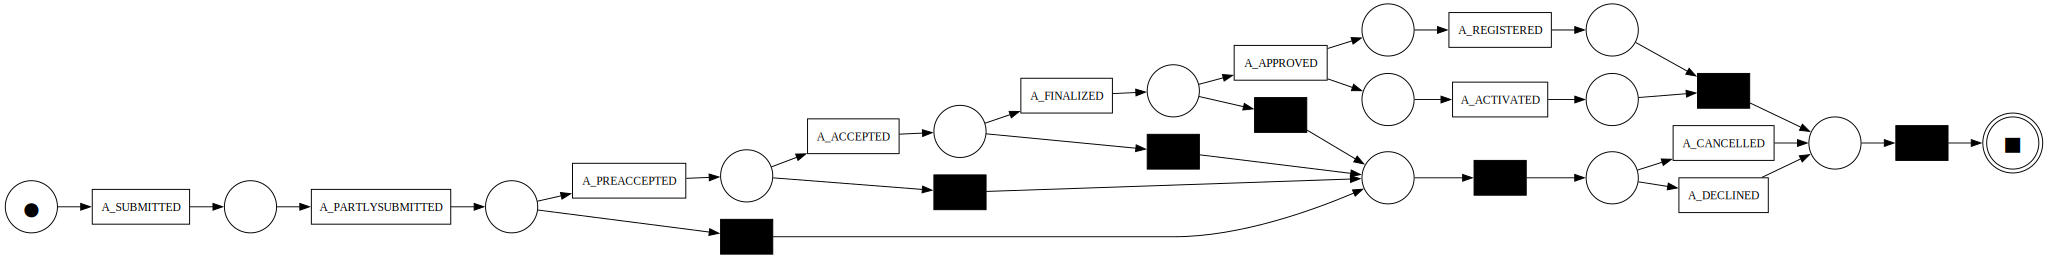

In [84]:
pm4py.visualization.petri_net.visualizer.apply(net,im,fm)

In [92]:
bpmn_model